Complete notebook available at: https://github.com/ai4up/ufo-prediction/blob/main/demo/demo.ipynb

## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [4]:
# -.-|m { input: false }

!pip install -r ../requirements.txt


  Using cached haversine-2.5.1-py2.py3-none-any.whl (6.1 kB)


In [4]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging
import copy

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
print(PROJECT_SRC_PATH)
sys.path.append(PROJECT_SRC_PATH)
PROJECT_EXPERIMENT_PATH = "C:\\Users\\utente\\ufo-prediction\\bin"
sys.path.append(PROJECT_EXPERIMENT_PATH)

import experiments

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison, HeightPredictor
import preprocessing as pp

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier

import dataset
from sklearn import metrics



logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

c:\Users\utente\ufo-prediction\demo\..\src


c:\Users\utente\anaconda3\Lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [23]:
!git lfs pull

In [5]:

import os


DATA_DIR = '.'

path_data_ESP = os.path.join(DATA_DIR, 'df-ESP-exp.pkl')
path_data_FRA = os.path.join(DATA_DIR, 'df-FRA-exp.pkl')
path_data_NLD = os.path.join(DATA_DIR, 'df-NLD-exp.pkl')

df = pd.read_pickle(path_data_ESP)
df2 = pd.read_pickle(path_data_FRA)
df3 = pd.read_pickle(path_data_NLD)




The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


21935
49266
176319
247520


In [6]:
# Create test and train-validation sets, in all the different combinations needed for both XGBoost and TF-Transformer eperiments

aux_set = df.sample(n=4000, random_state=2)
type_tl_ESPset = df.drop(aux_set.index)
height_test_ESPset = aux_set.iloc[:600, :]
#height_local_train_ESPset = aux_set.iloc[600:, :]


type_tl_ESPset = type_tl_ESPset.dropna(subset=["type"])
height_test_ESPset = height_test_ESPset.dropna(subset=["height"])

i=0
height_local_train_ESPset = aux_set.iloc[600+660*i:600+660*(i+1), :]
height_foreign_train_NLDset = df3.sample(n=20000, random_state=2)
df_train = pd.concat([height_local_train_ESPset, height_foreign_train_NLDset])
df_train = df_train.dropna(subset=["height"])

aux_set1 = copy.deepcopy(df_train)
aux_set2 = copy.deepcopy(height_test_ESPset)

height_foreign_train_NLDset = pd.concat([aux_set1, aux_set2])


# exportdf3 = copy.deepcopy(df3_ufo)

features_to_drop2 = [ 'type', 'geometry', 'source_file', 'Unnamed: 0.1', 'floors', 'TouchesIndexes', 'block', 'neighborhood', 'sbb', 'city']
height_test_ESPset.drop(features_to_drop2, axis=1, inplace=True)
# height_foreign_train_NLDset.drop(features_to_drop2, axis=1, inplace=True)
height_local_train_ESPset.drop(features_to_drop2, axis=1, inplace=True)



type_tl_target = type_tl_ESPset['type']
type_tl_target = pd.DataFrame([1 if obj == "residential" else 0 for obj in type_tl_target])

#height_tl_target = height_tl_ESPset['height']
height_foreign_train_NLDset_target = height_foreign_train_NLDset['height']


features_to_drop = ['type', 'type_source','height','age', 'type', 'geometry','source_file', 'Unnamed: 0.1', 'id_source', 'id', 'floors', 'TouchesIndexes', 'id_misaligned', 'block', 'country', 'neighborhood', 'sbb', 'city']

#height_tl_ESPset.drop(features_to_drop, axis=1, inplace=True)
type_tl_ESPset.drop(features_to_drop, axis=1, inplace=True)
height_foreign_train_NLDset.drop(features_to_drop, axis=1, inplace=True)

# height_tl_ESPset.to_csv('C:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoESP_downstream\\N.csv', index = False)
type_tl_ESPset.to_csv('C:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoESP_upstream\\N.csv', index = False)
height_foreign_train_NLDset.to_csv("c:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoNLD_direct\\N.csv", index = False)
# height_tl_target.to_csv('C:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoESP_downstream\\y.csv', index = False)
type_tl_target.to_csv('C:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoESP_upstream\\y.csv', index = False)
height_foreign_train_NLDset_target.to_csv("c:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoNLD_direct\\y.csv", index = False)

# height_tl_ESPset = pd.read_csv('C:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoESP_downstream\\N.csv')
type_tl_ESPset = pd.read_csv('C:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoESP_upstream\\N.csv')
height_foreign_train_NLDset = pd.read_csv('C:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoNLD_direct\\N.csv')
# height_tl_target = pd.read_csv('C:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoESP_downstream\\y.csv')
type_tl_target = pd.read_csv('C:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoESP_upstream\\y.csv')
height_foreign_train_NLDset_target = pd.read_csv("c:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoNLD_direct\\y.csv")

# height_tl_ESPset.to_csv('C:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoESP_downstream\\N.csv', index = False)
type_tl_ESPset.to_csv('C:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoESP_upstream\\N.csv', index = False)
height_foreign_train_NLDset.to_csv("c:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoNLD_direct\\N.csv", index = False)
# height_tl_target.to_csv('C:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoESP_downstream\\y.csv', index = False)
type_tl_target.to_csv('C:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoESP_upstream\\y.csv', index = False)
height_foreign_train_NLDset_target.to_csv("c:\\Users\\utente\\tabular-transfer-learning\\data\\eubuccoNLD_direct\\y.csv", index = False)




A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Prediction

In [2]:
xgb_model_params = {'tree_method': 'hist'}
xgb_hyperparams = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 250,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 0.5,
    'subsample': 1.0,
}

reg_params = {
    'max_depth': [10],
    'learning_rate': [0.1],
    'n_estimators': [350, 400, 450]
}

In [89]:
# Parameter tuning - with changing local train part

RESULT_DIR = "C:\\Users\\utente\\ufo-prediction\\results"

# height_local_train_ESPset = aux_set.iloc[600:, :]
# height_local_train_ESPset = height_local_train_ESPset.dropna(subset=["height"])
# height_local_train_ESPset.info()
# for i in range(5):
#     aux_local_train = aux_set.iloc[600*i : 600*(i+1), :]
#     print(height_local_train_ESPset.info())
    # df_tuning = pd.concat([aux_local_train, height_foreign_train_NLDset])
predictor = HeightPredictor(
    model=XGBRegressor(**xgb_model_params),
    df = height_foreign_train_NLDset,
    cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameter_tuning_only=True,
    hyperparameter_tuning_space=reg_params,
    preprocessing_stages=[pp.remove_outliers]
)
logger.info('Saving hyperparameter optimized model...')
timestr = time.strftime('%Y%m%d-%H-%M-%S')
path = f'{RESULT_DIR}\\model-optimized-{timestr}-{i}.pkl'
predictor.save(path, results_only=True)



2024-02-21 10:42:50,407 | INFO : Dataset length: 20000
2024-02-21 10:42:50,433 | INFO : Dataset allocated memory: 19 MB
2024-02-21 10:42:50,441 | INFO : No abort signal received. Continuing... To abort please create C:\Users\utente\ufo-prediction\metadata\local-ca1b3f6e.abort.
2024-02-21 10:42:50,444 | INFO : Dataset standard deviation: 2.51624475867245
2024-02-21 10:42:50,449 | INFO : Dataset mean age: 5.505932833505
2024-02-21 10:42:50,451 | INFO : Training dataset length: 20000
2024-02-21 10:42:50,453 | INFO : Test dataset length: 0
2024-02-21 10:42:50,663 | INFO : Test dataset standard deviation after preprocessing: nan
2024-02-21 10:42:50,667 | INFO : Test dataset mean age after preprocessing: nan
2024-02-21 10:42:50,669 | INFO : Training dataset length after preprocessing: 19786
2024-02-21 10:42:50,672 | INFO : Test dataset length after preprocessing: 0
The total space of parameters 3 is smaller than n_iter=20. Running 3 iterations. For exhaustive searches, use GridSearchCV.
pand

Fitting 5 folds for each of 3 candidates, totalling 15 fits


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 1/5] END learning_rate=0.1, max_depth=10, n_estimators=350;, score=(train=-0.027, test=-1.523) total time= 2.8min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 2/5] END learning_rate=0.1, max_depth=10, n_estimators=350;, score=(train=-0.029, test=-1.138) total time= 2.7min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 3/5] END learning_rate=0.1, max_depth=10, n_estimators=350;, score=(train=-0.030, test=-1.035) total time= 2.7min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 4/5] END learning_rate=0.1, max_depth=10, n_estimators=350;, score=(train=-0.027, test=-1.191) total time= 2.9min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 5/5] END learning_rate=0.1, max_depth=10, n_estimators=350;, score=(train=-0.029, test=-1.260) total time= 2.6min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 1/5] END learning_rate=0.1, max_depth=10, n_estimators=400;, score=(train=-0.018, test=-1.523) total time= 2.9min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 2/5] END learning_rate=0.1, max_depth=10, n_estimators=400;, score=(train=-0.020, test=-1.138) total time= 2.9min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 3/5] END learning_rate=0.1, max_depth=10, n_estimators=400;, score=(train=-0.020, test=-1.035) total time= 2.9min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 4/5] END learning_rate=0.1, max_depth=10, n_estimators=400;, score=(train=-0.018, test=-1.190) total time= 3.3min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 5/5] END learning_rate=0.1, max_depth=10, n_estimators=400;, score=(train=-0.019, test=-1.260) total time= 3.1min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 1/5] END learning_rate=0.1, max_depth=10, n_estimators=450;, score=(train=-0.013, test=-1.523) total time= 3.1min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 2/5] END learning_rate=0.1, max_depth=10, n_estimators=450;, score=(train=-0.014, test=-1.138) total time= 3.1min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 3/5] END learning_rate=0.1, max_depth=10, n_estimators=450;, score=(train=-0.014, test=-1.035) total time= 3.1min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 4/5] END learning_rate=0.1, max_depth=10, n_estimators=450;, score=(train=-0.013, test=-1.190) total time= 3.3min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 5/5] END learning_rate=0.1, max_depth=10, n_estimators=450;, score=(train=-0.014, test=-1.260) total time= 3.5min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
2024-02-21 11:31:20,818 | INFO : Best hyperparameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1}
2024-02-21 11:31:20,818 | INFO : Corresponding score: -1.2293064327385603
2024-02-21 11:31:20,971 | INFO : No abort signal received. Continuing... To abort please create C:\Users\utente\ufo-prediction\metadata\local-ca1b3f6e.abort.
2024-02-21 11:31:20,971 | INFO : Dataset standard deviation: 2.51624475867245
2024-02-21 11:31:20,987 | INFO : Dataset mean age: 5.505932833505
2024-02-21 11:31:20,989 | INFO : Training dataset length: 16000
2024-02-21 11:31:20,992 | INFO : Test dataset length: 4000
2024-02-21 11:31:21,200 | INFO : Test dataset standard deviation after preprocessing: 2.386129461215654
2024-02-21 11:31:21,200 | INFO : Test dataset mean age after preprocessing: 5.4486180414664975
2024-02-21 11:31:21,200 | INFO : Training datase

Fitting 5 folds for each of 3 candidates, totalling 15 fits


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 1/5] END learning_rate=0.1, max_depth=10, n_estimators=350;, score=(train=-0.019, test=-1.379) total time= 2.4min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 2/5] END learning_rate=0.1, max_depth=10, n_estimators=350;, score=(train=-0.018, test=-1.375) total time= 2.4min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 3/5] END learning_rate=0.1, max_depth=10, n_estimators=350;, score=(train=-0.019, test=-1.096) total time= 2.3min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 4/5] END learning_rate=0.1, max_depth=10, n_estimators=350;, score=(train=-0.016, test=-1.515) total time= 3.3min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV 5/5] END learning_rate=0.1, max_depth=10, n_estimators=350;, score=(train=-0.017, test=-1.137) total time= 3.3min


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


KeyboardInterrupt: 

### Regression

In [5]:
for i in range(5):
    height_local_train_ESPset = aux_set.iloc[600+660*i:600+660*(i+1), :]
    height_local_train_ESPset = height_local_train_ESPset.dropna(subset=["height"])

    df_train = pd.concat([height_local_train_ESPset, height_foreign_train_NLDset])
    
    predictor = HeightPredictor(
        model=XGBRegressor(**xgb_model_params),
        df = df_train,
        # test_training_split=pp.split_80_20,
        test_set = height_test_ESPset,
        early_stopping=True,
        hyperparameters=xgb_hyperparams,
        preprocessing_stages=[pp.remove_outliers]
        
    )
    print("scores for testing at iteration " + str(i)) 
    predictor.evaluate()

   

#xgboost
# 1.13 1.11 1.12 1.15 1.11 - average mae 1.12
#transfer
# 0.51 0.50 0.52 0.50 0.51 - average mae 0.51
#direct
# 0.43 0.42 0.45 0.61 0.45 0.43 0.46 0.44 0.46 - average mae 0.46 



2024-02-22 13:39:05,195 | INFO : Dataset length: 20649
2024-02-22 13:39:05,227 | INFO : Dataset allocated memory: 21 MB
2024-02-22 13:39:05,230 | INFO : No abort signal received. Continuing... To abort please create C:\Users\utente\ufo-prediction\metadata\local-422343d0.abort.
2024-02-22 13:39:05,230 | INFO : Dataset standard deviation: 2.53350739084524
2024-02-22 13:39:05,230 | INFO : Dataset mean age: 5.454557444433144
2024-02-22 13:39:05,230 | INFO : Training dataset length: 20649
2024-02-22 13:39:05,243 | INFO : Test dataset length: 580
2024-02-22 13:39:05,626 | INFO : Test dataset standard deviation after preprocessing: 2.6851100144730675
2024-02-22 13:39:05,631 | INFO : Test dataset mean age after preprocessing: 3.8615664845173043
2024-02-22 13:39:05,634 | INFO : Training dataset length after preprocessing: 20402
2024-02-22 13:39:05,637 | INFO : Test dataset length after preprocessing: 549
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pa

scores for testing at iteration 0
MAE: 1.13 
RMSE: 1.89 
R2: 0.5059


2024-02-22 13:40:23,872 | INFO : Dataset length: 20642
2024-02-22 13:40:23,911 | INFO : Dataset allocated memory: 21 MB
2024-02-22 13:40:23,911 | INFO : No abort signal received. Continuing... To abort please create C:\Users\utente\ufo-prediction\metadata\local-e61cdf43.abort.
2024-02-22 13:40:23,911 | INFO : Dataset standard deviation: 2.52843112598356
2024-02-22 13:40:23,922 | INFO : Dataset mean age: 5.453984917648484
2024-02-22 13:40:23,925 | INFO : Training dataset length: 20642
2024-02-22 13:40:23,928 | INFO : Test dataset length: 580
2024-02-22 13:40:24,308 | INFO : Test dataset standard deviation after preprocessing: 2.6851100144730675
2024-02-22 13:40:24,308 | INFO : Test dataset mean age after preprocessing: 3.8615664845173043
2024-02-22 13:40:24,308 | INFO : Training dataset length after preprocessing: 20400
2024-02-22 13:40:24,321 | INFO : Test dataset length after preprocessing: 549
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pa

scores for testing at iteration 1
MAE: 1.11 
RMSE: 1.91 
R2: 0.4906


2024-02-22 13:42:14,385 | INFO : Dataset length: 20648
2024-02-22 13:42:14,413 | INFO : Dataset allocated memory: 21 MB
2024-02-22 13:42:14,415 | INFO : No abort signal received. Continuing... To abort please create C:\Users\utente\ufo-prediction\metadata\local-d6d6d314.abort.
2024-02-22 13:42:14,418 | INFO : Dataset standard deviation: 2.539633797148305
2024-02-22 13:42:14,423 | INFO : Dataset mean age: 5.458332849191205
2024-02-22 13:42:14,425 | INFO : Training dataset length: 20648
2024-02-22 13:42:14,428 | INFO : Test dataset length: 580
2024-02-22 13:42:14,748 | INFO : Test dataset standard deviation after preprocessing: 2.6851100144730675
2024-02-22 13:42:14,751 | INFO : Test dataset mean age after preprocessing: 3.8615664845173043
2024-02-22 13:42:14,754 | INFO : Training dataset length after preprocessing: 20415
2024-02-22 13:42:14,757 | INFO : Test dataset length after preprocessing: 549
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use p

scores for testing at iteration 2
MAE: 1.12 
RMSE: 1.85 
R2: 0.5237


2024-02-22 13:42:54,773 | INFO : Dataset length: 20648
2024-02-22 13:42:54,797 | INFO : Dataset allocated memory: 21 MB
2024-02-22 13:42:54,800 | INFO : No abort signal received. Continuing... To abort please create C:\Users\utente\ufo-prediction\metadata\local-67be6170.abort.
2024-02-22 13:42:54,803 | INFO : Dataset standard deviation: 2.5226208695772776
2024-02-22 13:42:54,810 | INFO : Dataset mean age: 5.452521148300077
2024-02-22 13:42:54,812 | INFO : Training dataset length: 20648
2024-02-22 13:42:54,814 | INFO : Test dataset length: 580
2024-02-22 13:42:55,171 | INFO : Test dataset standard deviation after preprocessing: 2.6851100144730675
2024-02-22 13:42:55,173 | INFO : Test dataset mean age after preprocessing: 3.8615664845173043
2024-02-22 13:42:55,175 | INFO : Training dataset length after preprocessing: 20406
2024-02-22 13:42:55,178 | INFO : Test dataset length after preprocessing: 549
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use 

scores for testing at iteration 3
MAE: 1.15 
RMSE: 2.03 
R2: 0.4248


2024-02-22 13:43:29,065 | INFO : Dataset length: 20648
2024-02-22 13:43:29,092 | INFO : Dataset allocated memory: 21 MB
2024-02-22 13:43:29,095 | INFO : No abort signal received. Continuing... To abort please create C:\Users\utente\ufo-prediction\metadata\local-5e0901a9.abort.
2024-02-22 13:43:29,098 | INFO : Dataset standard deviation: 2.5346073644188567
2024-02-22 13:43:29,103 | INFO : Dataset mean age: 5.451431454382991
2024-02-22 13:43:29,105 | INFO : Training dataset length: 20648
2024-02-22 13:43:29,107 | INFO : Test dataset length: 580
2024-02-22 13:43:29,437 | INFO : Test dataset standard deviation after preprocessing: 2.6851100144730675
2024-02-22 13:43:29,439 | INFO : Test dataset mean age after preprocessing: 3.8615664845173043
2024-02-22 13:43:29,442 | INFO : Training dataset length after preprocessing: 20402
2024-02-22 13:43:29,445 | INFO : Test dataset length after preprocessing: 549
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use 

scores for testing at iteration 4
MAE: 1.11 
RMSE: 1.97 
R2: 0.4605


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


2024-03-17 21:58:13,778 | INFO : Dataset length: 649
2024-03-17 21:58:13,792 | INFO : Dataset allocated memory: 0 MB
2024-03-17 21:58:13,803 | INFO : No abort signal received. Continuing... To abort please create C:\Users\utente\ufo-prediction\metadata\local-87c36ab7.abort.
2024-03-17 21:58:13,806 | INFO : Dataset standard deviation: 2.554802707267641


2024-03-17 21:58:13,809 | INFO : Dataset mean age: 3.8713405238828966
2024-03-17 21:58:13,809 | INFO : Training dataset length: 649
2024-03-17 21:58:13,815 | INFO : Test dataset length: 580
2024-03-17 21:58:13,850 | INFO : Test dataset standard deviation after preprocessing: 2.6851100144730675
2024-03-17 21:58:13,855 | INFO : Test dataset mean age after preprocessing: 3.8615664845173043
2024-03-17 21:58:13,858 | INFO : Training dataset length after preprocessing: 616
2024-03-17 21:58:13,861 | INFO : Test dataset length after preprocessing: 549
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


MAE: 1.05 
RMSE: 1.86 
R2: 0.5172


2024-03-17 21:58:25,525 | INFO : (549, 1, 549, 1)


here


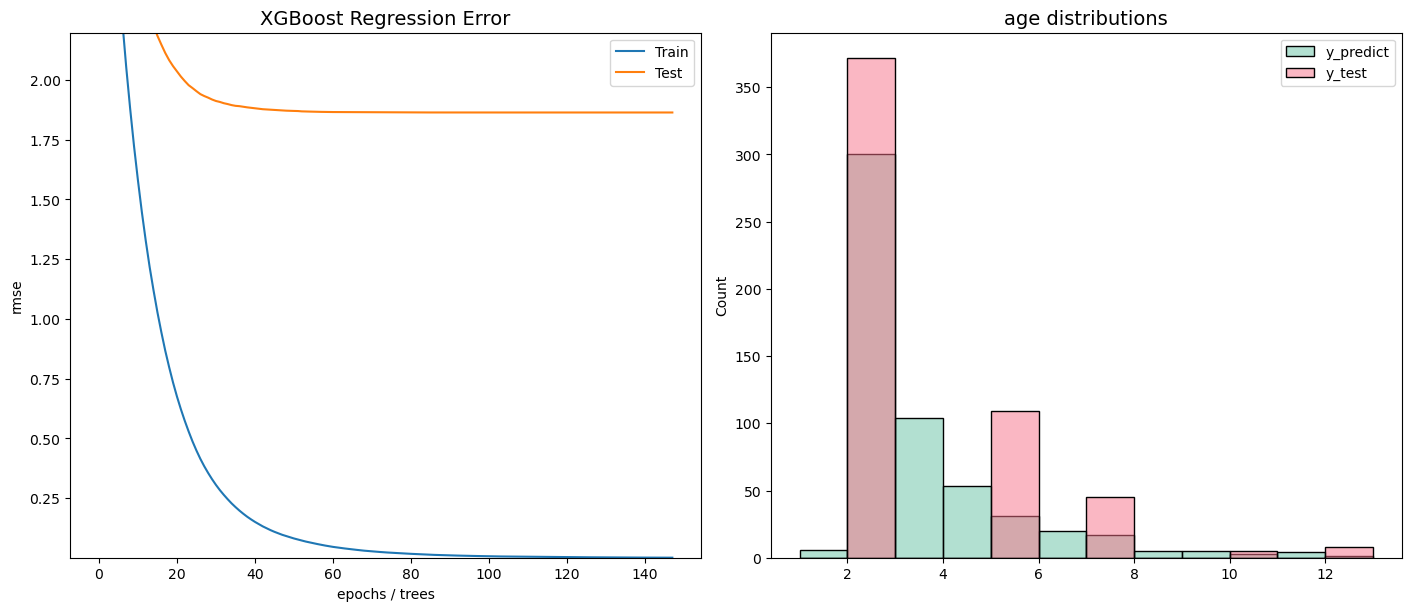

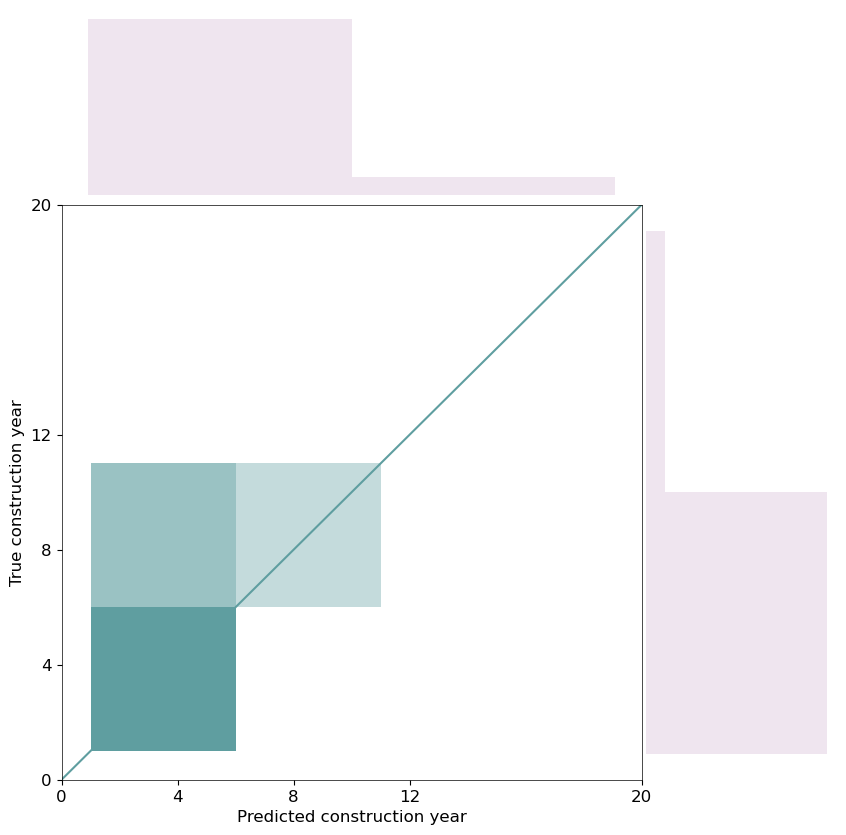

In [7]:
df_train = pd.concat([height_local_train_ESPset, height_foreign_train_NLDset])
predictor = HeightPredictor(
        model=XGBRegressor(**xgb_model_params),
        df = df_train,
        # test_training_split=pp.split_80_20,
        test_set = height_test_ESPset,
        early_stopping=True,
        hyperparameters=xgb_hyperparams,
        preprocessing_stages=[pp.remove_outliers]
        
    )
predictor.evaluate()


In [82]:
import math

height_test_ESPset = aux_set.iloc[:600, :]
df_final_test = copy.deepcopy(height_test_ESPset)
feature_cols = list(df_final_test.columns.intersection(dataset.FEATURES))

y_final_test = height_test_ESPset['height']
X_final_test = df_final_test[feature_cols]


y_predict_test = pd.DataFrame(
        {'height': predictor.model.predict(X_final_test)}, index=X_final_test.index)
# print("scores for final testing at iteration " + str(i))        
# print(metrics.mean_absolute_error(y_final_test, y_predict_test))
# print(np.sqrt(metrics.mean_squared_error(y_final_test, y_predict_test)))
# print(metrics.r2_score(y_final_test, y_predict_test) )

y_error = abs(y_predict_test['height']-y_final_test)

# y_error = y_error.apply(lambda x: np.log10(x))

y_error_df = pd.DataFrame(
        {'height': y_error}, index=X_final_test.index)


# 
# height_test_ESPset = height_test_ESPset.dropna(subset=["height"])
# clipped_gpd=height_test_ESPset.clip([3.4e6, 1.85e6, 3.414e6, 1.91e6])
# clipped_gpd = clipped_gpd.to_crs("EPSG:4326")
# clipped_gpd.plot('height', cmap="Set1", markersize = 0.9)

y_error.head()

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


3766  34013864    2.105864
      33995263    0.309085
      34006035    1.787661
5000  43624073    0.716485
3766  34006078    0.478494
Name: height, dtype: float64

In [83]:
df_toplot = height_test_ESPset.join(y_error_df, lsuffix='_caller', rsuffix='_absolute')
df_toplot.info()
df_toplot['geometry']


<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 600 entries, (3766, 34013864) to (3766, 34007862)
Columns: 137 entries, source_file to height_absolute
dtypes: float64(122), geometry(1), int64(2), object(12)
memory usage: 326.4+ MB


3766  34013864    POINT (3412435.143 1901599.959)
      33995263    POINT (3411117.833 1903098.035)
      34006035    POINT (3409398.510 1900694.184)
5000  43624073    POINT (3630795.607 2083200.023)
3766  34006078    POINT (3409365.002 1900828.001)
                               ...               
      34007829    POINT (3410188.467 1903847.312)
5000  43628143    POINT (3632044.249 2080456.564)
3766  33999018    POINT (3407725.261 1902440.238)
      34012658    POINT (3412174.045 1903117.783)
      34007862    POINT (3409624.969 1900186.872)
Name: geometry, Length: 600, dtype: geometry

<Axes: >

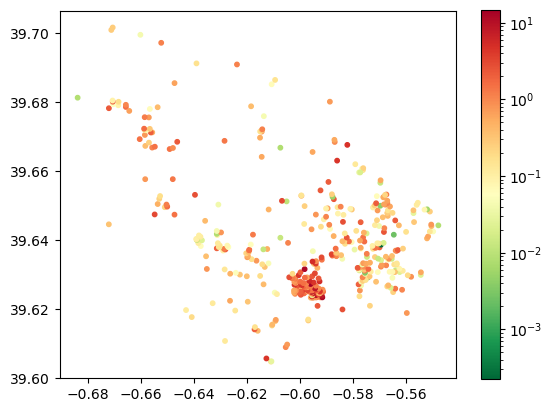

In [95]:
import matplotlib
clipped_gpd=df_toplot.clip([3.4e6, 1.85e6, 3.414e6, 1.91e6])
clipped_gpd = clipped_gpd.to_crs("EPSG:4326")
clipped_gpd.plot('height_absolute', cmap="RdYlGn_r", markersize = 10, legend = True, norm=matplotlib.colors.LogNorm(vmin=clipped_gpd.height_absolute.min(), vmax=clipped_gpd.height_absolute.max()))

1.1388212320105784
1.9492806000367895
0.4743145350660677


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### Classification

In [9]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = (1900, 2020, 10)

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    bin_config=equally_sized_bins,
    #bins=tabula_nl_bins,
)
classifier.evaluate()

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


KeyboardInterrupt: 

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [34]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2022-10-21 16:42:52,510 | INFO : Starting experiment Spain_random-cv...
2022-10-21 16:42:53,720 | INFO : Dataset length: 974
2022-10-21 16:42:53,726 | INFO : Dataset allocated memory: 1 MB
2022-10-21 16:42:53,731 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-1eb3cae2.abort.
2022-10-21 16:42:53,731 | INFO : Dataset standard deviation: 45.78138305502198
2022-10-21 16:42:53,732 | INFO : Dataset mean age: 1950.3613963039015
2022-10-21 16:42:53,733 | INFO : Training dataset length: 779
2022-10-21 16:42:53,733 | INFO : Test dataset length: 195
2022-10-21 16:42:53,748 | INFO : Test dataset standard deviation after preprocessing: 34.49407581359104
2022-10-21 16:42:53,749 | INFO : Test dataset mean age after preprocessing: 1958.8352272727273
2022-10-21 16:42:53,749 | INFO : Training dataset length after preprocessing: 710
2022-10-21 16:42:53,749 | INFO : Test dataset length after preprocessing: 176
`early_stopping_rounds` in `

In [35]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725
